# 06 Trees: Homework

In [104]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [105]:
df = pd.read_csv('jamb_exam_results.csv')

In [106]:
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


## Data Cleaning

In [107]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [108]:
df = standardise_colnames(df)

In [109]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [110]:
df.drop('student_id', axis=1, inplace=True, errors='ignore')
df.fillna(0, inplace=True)

## Validation Framework

In [111]:
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=1)

In [112]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [113]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

In [114]:
df_train.drop('jamb_score', axis=1, inplace=True, errors='ignore')
df_val.drop('jamb_score', axis=1, inplace=True, errors='ignore')
df_test.drop('jamb_score', axis=1, inplace=True, errors='ignore')

In [115]:
df_train.dtypes

study_hours_per_week              int64
attendance_rate                   int64
teacher_quality                   int64
distance_to_school              float64
school_type                      object
school_location                  object
extra_tutorials                  object
access_to_learning_materials     object
parent_involvement               object
it_knowledge                     object
age                               int64
gender                           object
socioeconomic_status             object
parent_education_level           object
assignments_completed             int64
dtype: object

## Feature Preparation

In [116]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.fillna(0).to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  encoded_data = dv.transform(df_dicts)

  return encoded_data, dv

In [117]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [118]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3000, 29)
(1000, 29)
(1000, 29)


## Decision Tree
### Basic Model

In [119]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [120]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Random Forest

In [121]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [122]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

42.13724207871227

## Parameter Tuning
### n_estimators

In [123]:
n_estimators = range(10, 201, 10)
random_state = 1

In [124]:
scores = []
for n in n_estimators:
  rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_val)
  rmse = root_mean_squared_error(y_val, y_pred)

  scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

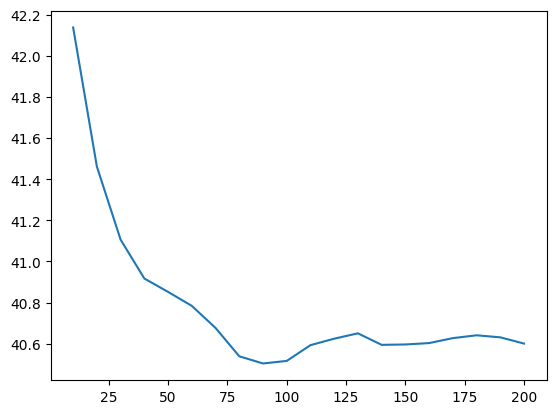

In [125]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

### max_depth

In [126]:
max_depths = [10, 15, 20, 25]

In [127]:
scores = []
for m in max_depths:
  for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((m, n, rmse))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

In [128]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

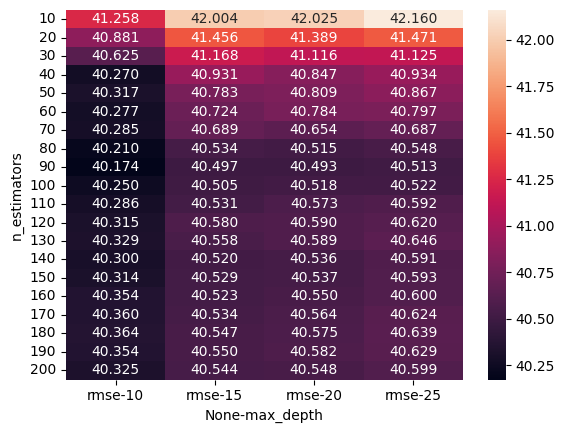

In [129]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

## Feature Importance

In [130]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [131]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


## Gradient Boosting

In [132]:
d_train = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=list(dv.get_feature_names_out()))
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [133]:
watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': 0.3, 
  'max_depth': 6,
  'min_child_weight': 1,
  
  'objective': 'reg:squarederror',
  'nthread': 8,
  
  'seed': 1,
  'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=100, evals=watchlist, verbose_eval=5)

[0]	train-rmse:42.69552	val-rmse:44.86028


[5]	train-rmse:34.43646	val-rmse:40.87186
[10]	train-rmse:31.55119	val-rmse:40.83684
[15]	train-rmse:29.08791	val-rmse:41.37832
[20]	train-rmse:27.24424	val-rmse:41.80313
[25]	train-rmse:25.52682	val-rmse:42.16423
[30]	train-rmse:24.12906	val-rmse:42.28557
[35]	train-rmse:22.40407	val-rmse:42.54946
[40]	train-rmse:21.45994	val-rmse:42.77917
[45]	train-rmse:20.39910	val-rmse:42.92252
[50]	train-rmse:19.30407	val-rmse:43.11630
[55]	train-rmse:18.42737	val-rmse:43.38441
[60]	train-rmse:17.42414	val-rmse:43.40830
[65]	train-rmse:16.59974	val-rmse:43.52522
[70]	train-rmse:15.74173	val-rmse:43.77894
[75]	train-rmse:14.87321	val-rmse:43.91229
[80]	train-rmse:14.28350	val-rmse:44.08528
[85]	train-rmse:13.64009	val-rmse:44.22602
[90]	train-rmse:12.90222	val-rmse:44.30365
[95]	train-rmse:12.05464	val-rmse:44.31210
[99]	train-rmse:11.56417	val-rmse:44.43210


In [134]:
y_pred = model.predict(d_val)
root_mean_squared_error(y_val, y_pred)

44.432098039002526

In [135]:
watchlist = [(d_train, 'train'), (d_val, 'val')]

xgb_params = {
  'eta': 0.1, 
  'max_depth': 6,
  'min_child_weight': 1,
  
  'objective': 'reg:squarederror',
  'nthread': 8,
  
  'seed': 1,
  'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=100, evals=watchlist, verbose_eval=5)

[0]	train-rmse:45.50072	val-rmse:46.99373


[5]	train-rmse:40.15460	val-rmse:43.05644
[10]	train-rmse:37.11353	val-rmse:41.55631
[15]	train-rmse:35.07766	val-rmse:40.70892
[20]	train-rmse:33.57997	val-rmse:40.37859
[25]	train-rmse:32.50134	val-rmse:40.21661
[30]	train-rmse:31.47315	val-rmse:40.20963
[35]	train-rmse:30.68870	val-rmse:40.19360
[40]	train-rmse:29.89807	val-rmse:40.15747
[45]	train-rmse:29.33094	val-rmse:40.21096
[50]	train-rmse:28.58793	val-rmse:40.28533
[55]	train-rmse:27.95277	val-rmse:40.44296
[60]	train-rmse:27.26360	val-rmse:40.55054
[65]	train-rmse:26.56706	val-rmse:40.66625
[70]	train-rmse:26.05959	val-rmse:40.73555
[75]	train-rmse:25.55747	val-rmse:40.76267
[80]	train-rmse:25.13835	val-rmse:40.82813
[85]	train-rmse:24.64140	val-rmse:40.87915
[90]	train-rmse:23.93958	val-rmse:40.89645
[95]	train-rmse:23.39469	val-rmse:40.95651
[99]	train-rmse:23.14487	val-rmse:41.04335


In [136]:
y_pred = model.predict(d_val)
root_mean_squared_error(y_val, y_pred)

41.043354592351655